# Load, fit, and analyse the waveforms from a PMT

This script contians the required functions to load the PMT outputs from an XML file (outputs of the CAEN software) into a Pandas dataframe, then integrate the waveforms to get an integrated charge, and return the mean value

## Load the required libraries

In [249]:
!pip install -U pip
!pip install lmfit
!pip install pyarrow

In [250]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.signal
import pandas as pd
import time
import traceback
from glob import glob
#from sys import argv
from os.path import splitext, exists
from lmfit.models import ConstantModel, GaussianModel
from lmfit import Model
from datetime import datetime as dt
from random import randrange
from pathlib import Path

import argparse

shingo_model = True

## Set up the constants

In [251]:
# Resolution of the CAEN digitiser
digi_res = 2 #4 # ns
qhist_bins = 500 #750 # Number of bins to use when fitting and histing qint
peak_prominence_fac = 200 # Prominance will be max value of hist/this
digi_channels = 4 # number of channels in the digitiser

#gain_val = 5.76e6 # Gain for he Hamamatsu PMT at 1058 V
gain_val = 4.06e6 # NNVT Gain
 
# Basic physical constants
e_const = 1.602e-19

# What to scale the gain calc by (to get diff units)
# Digitiser resolution in ns, switch to s
# Switch mV to V
# Divide by e to get to gain
gain_scale = digi_res*1e-9*1e-3/e_const

# Resistance of cable
gain_scale /= 50 # Ohm

# for converting [ADC*Sample] to [pC] at plotting
charge_scale = digi_res/50. # 2 [ns] sample ADC, [mV] / 50 ohms in [pC]

In [252]:
parser = argparse.ArgumentParser(description='PMT waveform analysis. WARNING: --show_plots and --save_figs cannot be used together. Same for --q and --dr')
parser.add_argument('--redo_feather', action='store_true', help='if you want to regenerate this file.')
parser.add_argument('--save', action='store_true', help='Saves the fit information to csv.')
parser.add_argument('--save_plots', action='store_true', help='Saves the qfit and wform plots to the input dir.')
parser.add_argument('--show_plots', action='store_true', help='Shows the plots instead of saving them to file.')
parser.add_argument('--q', action='store_true', help='Integrate peaks to measure gain, PEres/sigma, PV ratio.')
parser.add_argument('--dr', action='store_true', help='Dark rate calculation, count peaks above thresholds.')
parser.add_argument('--wf', action='store_true', help='Just draw some sample waveforms.')
parser.add_argument('--file', '-f', type=list, help='Input file path')
parser.add_argument('--channels', type=list, help='The labels for each channels (usually which PMT is connected).')
parser.add_argument('--fit_model', type=str, help='luminous')
parser.add_argument('--process_ch', type=str, help='Select a channel number to be processed. (For the LED measurement)')


_StoreAction(option_strings=['--process_ch'], dest='process_ch', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help='Select a channel number to be processed. (For the LED measurement)', metavar=None)

In [253]:
def get_channel_labels(args):
    """
    Parse argv to get the labels of each channel, usually which PMT is connected
    """
    # Default to generic labelling if none are given 
    if args.channels:
        return args.channels
    else:
        print("No channel labels given, will use default labelling.")
        print("Use --channels [label1] [label2] ... to label channels.")
        return [f"Channel {i}" for i in range(digi_channels)]


## Process the files

In [255]:
def draw_waveforms(args):
    fnames = args.file

    for fname in fnames:
        print('Processing file',fname)
        split_fname = splitext(fname)

        #Get input voltage
        base = Path(fname).stem
        brand, model, voltage = base.split("_")
        if voltage[-1] == "V":
            voltage = float(voltage[:-1])

        # Keep American spelling for consistency...
        wforms, _, vbin_width, _, _ = load_wforms(args,fname)
        ch = int(args.process_ch)

        xs = [digi_res*x for x in range(len(wforms[ch][0]))] # all waveforms are the same
        for k in range(6):
            i = randrange(len(wforms[ch]))
            print(i)
            wform = wforms[ch][i]*vbin_width

            wform_fig, wform_ax = plt.subplots()
            wform_ax.plot(xs, wform, label='Waveform')

            search_region_lim_1 = int(len(wform)/4)
            search_region_lim_2 = int(len(wform)/2)
            peak_i = np.argmin(wform[search_region_lim_1:search_region_lim_2])
            peak_i += search_region_lim_1

            # N bins pre/post the peak to calculate the integral from
            win_pre = 5 #3
            win_post = 150 #30 #10 #7

            wform_ax.axvline((peak_i-3)*digi_res,linestyle="--",color='gray',label='Short gate')
            wform_ax.axvline((peak_i+10)*digi_res,linestyle="--",color='gray')
            wform_ax.axvline((peak_i-win_pre)*digi_res,linestyle="--",color='k',label='Long Gate')
            wform_ax.axvline((peak_i+win_post)*digi_res,linestyle="--",color='k')

            # Get baseline from average of all points outside window
            non_peak = np.append(wform[:peak_i-win_pre], wform[peak_i+win_post:])
            # Truncated mean, only use the middle 50% of values.
            non_peak.sort()
            non_peak_lim = int(len(non_peak)/4)
            non_peak = non_peak[non_peak_lim:-non_peak_lim]
            baseline = sum(non_peak)/len(non_peak)
            wform_ax.axhline(baseline,linestyle="-",color='r',label='Baseline')

            wform_ax.set_xlabel("Time [ns]")
            wform_ax.set_ylabel("Output Voltage [mV]")
            wform_ax.legend()
            #wform_fig.show()
            wform_ax.set_title(f'Input PMT Voltage: {voltage} V')
            wform_fig.savefig(f"{split_fname[0]}_{k}_wform.pdf")
    
    return


In [257]:
def process_files_dr(args):
    fnames = args.file
    # Thresholds to scan to check dark rate
    n_thresh = 19
    thresholds = np.linspace(-1,-10, n_thresh)
    #thresholds = [-1]

    dr_fig, dr_ax = plt.subplots()

    channel_labels = get_channel_labels(args)
    for fname in fnames:
        try:
            channels, vrange, vbin_width, trig_window, clocktime = load_wforms(args,fname)
            print('Loaded waveforms successfully!')
            passes, passed_clocktime = process_wforms_dr(channels, vbin_width, trig_window,
                                                         thresholds, channel_labels, clocktime)

            csv_fname = splitext(fname)[0]+"_dr.csv"
            passes.to_csv(csv_fname, index=False)
            print("Saved dark count info to " + csv_fname)

            pkl_clocktime_fname = splitext(fname)[0]+'_dr_clocktime.pkl'
            passed_clocktime.to_pickle(pkl_clocktime_fname)
            print('Saved dark event time to ' + pkl_clocktime_fname)
            
            # for i,dr in enumerate(drs):
            # TODO CATCH THE SPECIFIC ERRORS
            for i in range(len(channels)):
                try:
                    dr = passes[channel_labels[i] + "_dr"]
                except:
                    print(f"No channel {i} data, won't plot.")
                    continue
                dr_ax.plot(thresholds, dr, label=channel_labels[i])
                dr_ax.scatter(thresholds, dr, marker="x")

            dr_fig.set_size_inches(14,8)

            dr_ax.axhline(2000, linestyle='-', color='black', label=r'2 kHz(requirement)')
            fontsize = 15
            dr_ax.legend(fontsize=fontsize)
            dr_ax.set_ylabel("Dark rate [/s]", fontsize=fontsize)
            dr_ax.set_xlabel("Threshold [mV]", fontsize=fontsize)
            dr_ax.set_yscale("log")

            dr_ax.tick_params(labelsize=fontsize)

            f_basename = splitext(fname)[0]

            # Pickle the fig and ax for future editing.
            mpl_fname = f_basename + "_dr_mpl.pkl"
            with open(mpl_fname, "wb") as f:
                pickle.dump((dr_fig, dr_ax), f)
                print("Saved mpl fig and axes to " + mpl_fname)

            # TODO: Make both work together (save, show, cla?)
            if args.show_plots:
                plt.show()
            elif args.save_plots:
                dr_fig.savefig(f"{splitext(fname)[0]}_dr.pdf", dpi=300)
                #plt.cla()
        except Exception:
            traceback.print_exc()

    return

## Analyse and integrate the waveforms

In [258]:
def load_wforms(args, fname):
    """
    Opens CAEN digitizer XML output and returns waveforms and digitiser 
    setttings.

    :param str fname: filename of input XML.
    """
    print("File: %s" % fname)
    split_fname = splitext(fname)

    feather_fname = split_fname[0]+"_wforms.feather"
    feather_clocktime_fname = split_fname[0]+'_clocktime.feather'

    print("Parsing XML...")
    # fname may be xml regardless but saves a logic gate
    try:
        tree = ET.parse(fname)
        root = tree.getroot()
        print("... done!")
    except FileNotFoundError:
        print(f"FileNotFoundError: {fname} not found.")
        print("The xml is required for digitiser info, please ensure xml files is"
            "passed (feather will automatically be used).")
        exit()

    # Get voltage range and resolution
    digi = root.find("digitizer")
    vrange_xml = digi.find("voltagerange").attrib
    # Convert strings to floats for hi and low.
    vlow = float(vrange_xml["low"])
    vhi = float(vrange_xml["hi"])
    vrange = (vlow, vhi)

    res = digi.find("resolution").attrib["bits"]
    # Convert bins to charge
    # Get voltage range from digitiser, divide by number of bins (2^number
    # of bits). 
    vbin_width = (vrange[1]-vrange[0])/(2**int(res))
    # Convert to mV
    vbin_width *= 1e3

    res = digi.find("resolution").attrib["bits"]

    # Get the trigger window
    trig_window = root.find("settings").find("window")
    trig_window = float(trig_window.attrib["size"])

    n_channels = int(digi.find("channels").attrib["value"])
    # ith wforms is the list of wforms for channel i of digi
    channels = [[] for i in range(n_channels)]
    # Store "clocktime"
    clocktime = [[] for i in range(n_channels)]

    # Check if there's a feather file to pull from
    # Skip if this is going to be regenerated
    if exists(feather_fname) and exists(feather_clocktime_fname) and (not args.redo_feather):
        print("Loading wforms from feather...")
        channels = pd.read_feather(feather_fname)
        clocktime = pd.read_feather(feather_clocktime_fname)
        # Prog written on assumption channels is list of lists of wforms
        # Transpose and put back in this form
        # TODO: Keep as pandas maybe?
        channels = channels.T.values.tolist()
        clocktime = clocktime.T.values.tolist()
        
        # Remove None-s from channels (filled when made into a df)
        for i in range(len(channels)):
            channels[i] = [x for x in channels[i] if x is not None]
            clocktime[i] = [x for x in clocktime[i] if x is not None]

        n_wforms = sum([len(wforms) for wforms in channels])
        print("... done! %i waveforms loaded." % n_wforms)

        return channels, vrange, vbin_width, trig_window, clocktime

    # Pull wforms from the xml
    print("Loading waveforms...")
    # Loops through every "event" in the XML, each with a "trace" (waveform)
    for i,child in enumerate(root.iter("event")):
        # Trace is spaced wform values. Split on spaces and convert to np array.
        # Use int as dtype to ensure numpy arithmetic.
        for wform in child.iter("trace"):
            wform_channel = int(wform.attrib["channel"])
            wform = np.array(wform.text.split()).astype(int)
            channels[wform_channel].append(wform)
            clocktime[wform_channel].append(child.attrib['clocktime'])
        
        if (i % 100) == 0:
            print(f"    {i} events loaded...\r", end="")

    # Remove unfilled (unused) channels
    channels = [channel for channel in channels if len(channel)!=0]
    clocktime = [clock for clock in clocktime if len(clock)!=0]

    print(f"... done! {i*len(channels)} waveforms loaded.")

    # for i,wforms in enumerate(channels):
    #     if len(wforms) == 0:
    #         continue
    #     tot_wform = None
    #     for wform in wforms:
    #         if tot_wform is None:
    #             tot_wform = wform
    #         else:
    #             tot_wform += wform
    #     plt.plot(range(len(tot_wform)), (tot_wform - np.mean(tot_wform)), label=f"Channel {i}")

    # plt.legend()
    # plt.show()
    # exit()

    # Convert waveforms to dataframe, save to feather
    # Get digi info straight from the XML
    # List of lists like channels needs transposing so channels are columns
    channels_df = pd.DataFrame(channels).T
    # Feather needs string column names
    channels_df.columns = channels_df.columns.map(str)
    channels_df.to_feather(feather_fname)
    
    print('len(clocktime)', len(clocktime))
    clocktime_df = pd.DataFrame(clocktime).T
    clocktime_df.columns = clocktime_df.columns.map(str)
    clocktime_df.to_feather(feather_clocktime_fname)

    print(f"Saved wforms to {feather_fname}.")

    return channels, vrange, vbin_width, trig_window, clocktime

In [263]:
def process_wforms_dr(channels, vbin_width, trig_window, thresholds,    channel_labels, clocktime):
    passes = [[0]*len(thresholds) for i in range(len(channels))]
    
    passed_clocktime = [ [ [] for i in range(len(thresholds)) ] for j in range(len(channels)) ]
    print('len(clocktime)', len(clocktime))
    #print('clocktime', clocktime)
    #print('channel_labls', channel_labels)
    #print('channels', channels)
    #df_clocktime = pd.DataFrame({'A':[1,2,3], 'B':[3,2,1]})
    #start = time.time()
    # Check how many are checked in each channel
    #n_checked = [0]*len(channels)
    for i,wforms in enumerate(channels):
        for j,wform in enumerate(wforms):
            ##n_checked[i] += 1
            if(j % 100 == 0):
                print(f"Waveforms checked: {j}\r",end="")

            wform_trunc = wform.copy()
            # Truncated mean, only use the middle 50% of values to find baseline
            wform_trunc.sort()
            wform_trunc_lim = int(len(wform_trunc)/4)
            wform_trunc = wform_trunc[wform_trunc_lim:-wform_trunc_lim]
            baseline = sum(wform_trunc)/len(wform_trunc)

            # Offset to 0 and scale to be voltage
            # Using np array is much quicker here
            wform_offset = np.array(wform, dtype=np.float64)
            wform_offset -= baseline
            wform_offset *= vbin_width
            wform_min = min(wform_offset)

            # if wform_min < thresholds[int(len(thresholds)/2)]:
            #     plt.plot(wform_offset)
            #     plt.show()
            #     exit()

            for k,threshold in enumerate(thresholds):
                in_peak = False
                for x in wform_offset:
                    if x > threshold:
                        in_peak = True
                    elif in_peak:
                        # No longer in peak beyond thresh, set to out of peak and
                        # iterate up.
                        in_peak = False
                        passes[i][k] += 1
                        #print('ct', clocktime[i][j])
                        passed_clocktime[i][k].append(int(clocktime[i][j]))
                # if wform_min < threshold:
                #     passes[i] += 1
    #print(f"Time taken: {time.time() - start}")

    # Only store passes for channels that had data
    #passes_tidy = []
    #for passx, checks in zip(passes,n_checked):
    #    if checks > 0:
    #        passes_tidy.append(passx)

    # Transpose to have channels as columns
    #passes_df = pd.DataFrame(passes_tidy).T
    passes_df = pd.DataFrame(passes).T

    # Rename up to the number of channels that actually have data (len(passes))
    pass_cols = [(ch+"_passes") for ch in channel_labels[:len(passes)]]
    passes_df.columns = pass_cols
    passes_df["threshold"] = thresholds

    # Reorder to put thresholds on the first column for improved readability
    cols_nothresh = [x for x in passes_df.columns.tolist() if x != "threshold"]
    passes_df = passes_df[["threshold"] + cols_nothresh]

    # Go through each channel and scale by total livetime to get dark rate
    for i in range(len(passes)):
        if len(channels[i]) == 0:
            continue

        # Scale passes for all thresholds in channel
        dr = [x/(len(channels[i])*trig_window*1e-9) for x in passes[i]]
        passes_df[channel_labels[i] + "_dr"] = dr
        dr_error = [error( (x, np.sqrt(x)), (len(channels[i])*trig_window*1e-9, 0.), method='/') for x in passes[i]]
        passes_df[channel_labels[i] + "_dr_error"] = dr_error

    #print(passes_df)

    # plt.plot(thresholds, passes)
    # plt.scatter(thresholds, passes, marker="x")
    # plt.show()

    # pass_percent = n_passes*100.0/len(wforms)

    # print(f"{n_passes} of {len(wforms)} wforms passed threshold ({pass_percent}%).")
    
    #passed_clocktime_tidy = []
    #for passx, checks in zip(passed_clocktime,n_checked):
    #    if checks > 0:
    #        passed_clocktime_tidy.append(passx)
            
    passed_clocktime_df = pd.DataFrame(passed_clocktime).T
    #passed_clocktime_df = pd.DataFrame().from_dict(passed_clocktime).T
    cols = [(ch) for ch in channel_labels[:len(passes)]]
    passed_clocktime_df.columns = cols
    passed_clocktime_df['threshold'] = thresholds
    
    return passes_df, passed_clocktime_df

## Load the files and run the code

In [271]:
### Dark ###
'''
files = [
    '../../from_Alex/pmt_measurements/dr/202308221609_900v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1000v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1100v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1200v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221609_1300v.xml',
    '../../from_Alex/pmt_measurements/dr/202308221212-1600_1100v_1000v_1000v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_900v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1000v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1100v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1200v.xml',
    '../../data/2023-10-17-DR/NNVT_CH0_PN2304-1470_900v_CH1_PN2305-1100_1300v.xml'
]
'''

files_dr = [
  '../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1270V_Ch15-HAM_KM56213_1050V_AfterWeekend.xml',
  '../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1273V_Ch15-HAM_KM56213_1050V_After5Min.xml',
  '../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1273V_Ch15-HAM_KM56213_1050V_ShorterPulse.xml',
  '../../DarkRate/Ch11_NNVT_PN2305-1100_1270V_Ch15_HAM_KM56213_1060V_Monday19082024.xml',
  '../../DarkRate/Ch11_NNVT_PN2305-1100_1270V_Ch15_HAM_KM56213_1060V_Monday19082024_Faster.xml',
]

#files = [
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-1.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-2.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-3.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-4.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-5.xml',
    #'../../data/2024-02-05_DR_LONG/CH0_KM56206_1076v_CH1_KM56213_983v_CH2_PN2304-1470_1014v_CH3_PN2305-1100_1195v-6.xml'
#]
#files = [
#    '../../data/2024-02-15_DR/CH0_PN2304-1470_1025v_CH1_H11901P-04_0.9v_wXeLight.xml'
#]
### ###

### Gain=5e6 ###

#files = [
#    '../../data/2024-02-22_LED/HAM_KM56213_1058v.xml',
#    '../../data/2024-02-22_LED/HAM_KM56206_1122v.xml',
#    '../../data/2024-02-22_LED/NNVT_PN2304-1470_1066v.xml',
#    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1345v.xml'
#]
#files = [
#    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1250v.xml',
#    '../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.xml'
#]
### ###


File: ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1270V_Ch15-HAM_KM56213_1050V_AfterWeekend.xml
Parsing XML...
... done!
Loading wforms from feather...
... done! 2000000 waveforms loaded.
Loaded waveforms successfully!
len(clocktime) 2
Saved dark count info to ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1270V_Ch15-HAM_KM56213_1050V_AfterWeekend_dr.csv
Saved dark event time to ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1270V_Ch15-HAM_KM56213_1050V_AfterWeekend_dr_clocktime.pkl
Saved mpl fig and axes to ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1270V_Ch15-HAM_KM56213_1050V_AfterWeekend_dr_mpl.pkl
File: ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1273V_Ch15-HAM_KM56213_1050V_After5Min.xml
Parsing XML...
... done!
Loading waveforms...
... done! 72640 waveforms loaded.
len(clocktime) 2
Saved wforms to ../../DarkRate/Ch11-NNVT_PN2305-1100(New)_1273V_Ch15-HAM_KM56213_1050V_After5Min_wforms.feather.
Loaded waveforms successfully!
len(clocktime) 2
Saved dark count info to ../../DarkRate/Ch11-NNVT_PN23

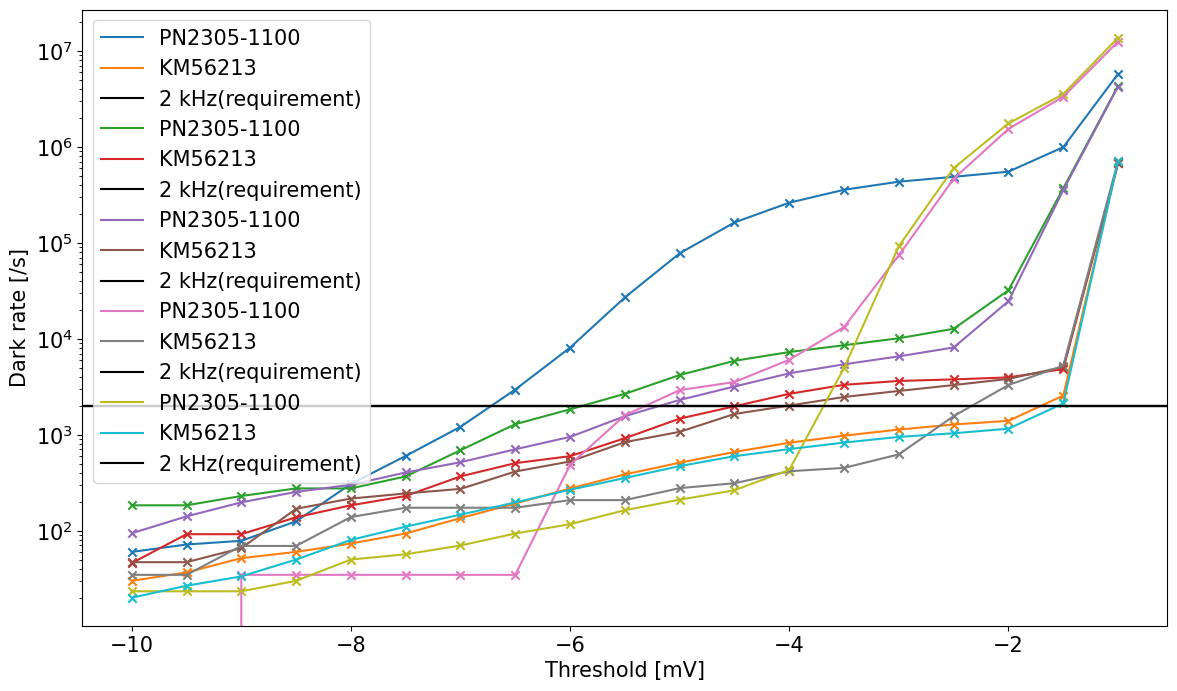

In [272]:
#ch_labels = ['PN2304-1470', 'PN2305-1100']
#ch_labels = ['KM56206', 'KM56213', 'PN2304-1470', 'PN2305-1100']
ch_labels = ['PN2305-1100', 'KM56213']
#ch_labels = ['PN2304-1470', 'H11901P-04']
#ch_labels = ['KM56206', 'H11901P-04']
#ch_labels = ['PN2305-1100', 'KM56213']
#ch_labels = ['KM56213'] # for DR measurement
#fit_model = 'luminous'
#fit_model = ''

options = ['--dr', '--save', '--save_plots', '-f', files_dr, '--channels', ch_labels] # Dark rate measurement#

args = parser.parse_args(args=options)

fnames = args.file
if args.dr:
    process_files_dr(args)
else:
    process_files(args)
